In [2]:
import os
import json 

In [2]:
#open debate summary
def open_debate_summary(debate_id):
    #list all files in data/debates/debate_id/summaries
    files = os.listdir(f"data/debates/{debate_id}/summaries")
    #open each file and read the json
    data = []
    for file in files:
        with open(f"data/debates/{debate_id}/summaries/{file}", "r") as f:
            data.append(json.load(f))
    
    return data

def open_reconstructed_summaries(debate_id):
    #list all files in data/debates/debate_id/reconstructed_summaries
    files = os.listdir(f"data/debates/{debate_id}/reconstructed_summaries/qwen3:30b-a3b")
    collected_data = []
    #open each file and read the json
    data_original, data_english = [], []
    for file in files:
        if file not in collected_data:
            if "_org_" in file:
                with open(f"data/debates/{debate_id}/reconstructed_summaries/qwen3:30b-a3b/{file}", "r") as f:
                    j = json.load(f)
                    for o in j:
                        o['zero_shot'] = 'zero_shot' in file
                    data_original.extend(j)
                collected_data.append(file)
                file = file.replace("_org_", "_en_")
                with open(f"data/debates/{debate_id}/reconstructed_summaries/qwen3:30b-a3b/{file}", "r") as f:
                    j = json.load(f)
                    for o in j:
                        o['zero_shot'] = 'zero_shot' in file
                    data_english.extend(j)
                collected_data.append(file)
            if "_org." in file:
                with open(f"data/debates/{debate_id}/reconstructed_summaries/qwen3:30b-a3b/{file}", "r") as f:
                    j = json.load(f)
                    for o in j:
                        o['zero_shot'] = 'zero_shot' in file
                    data_original.extend(j)
                collected_data.append(file)
                file = file.replace("_org.", "_en.")
                with open(f"data/debates/{debate_id}/reconstructed_summaries/qwen3:30b-a3b/{file}", "r") as f:
                    j = json.load(f)
                    for o in j:
                        o['zero_shot'] = 'zero_shot' in file
                    data_english.extend(j)
                collected_data.append(file)
    print(collected_data)
    
    return data_original, data_english

In [3]:
files = os.listdir(f"data/debates/CRE-20060118-ITEM-008/reconstructed_summaries/qwen3:30b-a3b")
files 

['CRE-20060118-ITEM-008_claude_org_zero_shot.json',
 'CRE-20060118-ITEM-008_gpt_structured_en.json',
 'CRE-20060118-ITEM-008_claude_structured_org.json',
 'CRE-20060118-ITEM-008_claude_en_zero_shot.json',
 'CRE-20060118-ITEM-008_claude_structured_en.json',
 'CRE-20060118-ITEM-008_gpt_structured_org.json']

In [4]:
data = []
for debate in os.listdir('data/debates'):
    data.extend(open_debate_summary(debate))

In [5]:
data_original, data_english = [], []
for debate_id in os.listdir("data/debates"):
    d_o, d_e = open_reconstructed_summaries(debate_id)
    data_original.extend(d_o)
    data_english.extend(d_e)

['CRE-20060404-ITEM-006_claude_org_zero_shot.json', 'CRE-20060404-ITEM-006_claude_en_zero_shot.json', 'CRE-20060404-ITEM-006_claude_structured_org.json', 'CRE-20060404-ITEM-006_claude_structured_en.json']
['CRE-20060118-ITEM-008_claude_org_zero_shot.json', 'CRE-20060118-ITEM-008_claude_en_zero_shot.json', 'CRE-20060118-ITEM-008_claude_structured_org.json', 'CRE-20060118-ITEM-008_claude_structured_en.json', 'CRE-20060118-ITEM-008_gpt_structured_org.json', 'CRE-20060118-ITEM-008_gpt_structured_en.json']
['CRE-20060214-ITEM-004_claude_structured_org.json', 'CRE-20060214-ITEM-004_claude_structured_en.json', 'CRE-20060214-ITEM-004_claude_org_zero_shot.json', 'CRE-20060214-ITEM-004_claude_en_zero_shot.json', 'CRE-20060214-ITEM-004_gpt_structured_org.json', 'CRE-20060214-ITEM-004_gpt_structured_en.json']
['CRE-20060316-ITEM-005_claude_org_zero_shot.json', 'CRE-20060316-ITEM-005_claude_en_zero_shot.json', 'CRE-20060316-ITEM-005_claude_structured_org.json', 'CRE-20060316-ITEM-005_claude_structu

In [11]:
from experiments.utils.bertscore import compute_bertscore_advanced
from tqdm import tqdm

def cross_lingual_eval(data):
    """
    compare multilingual BERTScore between the original text and (i) summary_english (ii) summary_original
    """

    original_text = []
    summary_english = []
    summary_original = []
    meta = []

    for d in tqdm(data):
        summ_eng = json.dumps(d['summary_english'])
        summ_orig = json.dumps(d['summary_original'])
        if len(summ_eng) > 100 and len(summ_orig) > 100:
            original_text.append(d['original'])
            summary_english.append(summ_eng)
            summary_original.append(summ_orig)
            meta.append(d)

    #calculate BERTScore for original text and summary_english
    bertscore_original_english = compute_bertscore_advanced(references=original_text, candidates=summary_english)
    bertscore_original_original = compute_bertscore_advanced(references=original_text, candidates=summary_original)

    for i in range(len(meta)):
        meta[i]['bertscore_original_english'] = bertscore_original_english['f1'][i]
        meta[i]['bertscore_original_original'] = bertscore_original_original['f1'][i]

    return meta


In [28]:
import re

def cleanup_string(s):
    """
    remove text between think tags
    """
    if s:
        parts = s.split("</think>")
    else:
        parts = []
        
    if len(parts) > 1:
        return parts[-1]
    else:
        return s

def cross_lingual_attention(data_original, data_english):

    """
    compare multilingual BERTScore between the original text and (i) reconstructed_position in english and (ii) reconstructed_position in the original language
    """
    original_text = []  
    reconstructed_position_english = []
    reconstructed_position_original = []
    meta = []

    for d_o, d_e in zip(data_original, data_english):
        original_text.append(d_o['original'])
        reconstructed_position_english.append(cleanup_string(d_e['reconstructed_position']))
        reconstructed_position_original.append(cleanup_string(d_o['reconstructed_position']))
        d_o['reconstructed_position_original'] = cleanup_string(d_o['reconstructed_position'])
        d_o['reconstructed_position_english'] = cleanup_string(d_e['reconstructed_position'])
        meta.append(d_o)

    bertscore_original_english = compute_bertscore_advanced(references=original_text, candidates=reconstructed_position_english)
    bertscore_original_original = compute_bertscore_advanced(references=original_text, candidates=reconstructed_position_original)

    for i in range(len(meta)):
        meta[i]['bertscore_original_english'] = bertscore_original_english['f1'][i]
        meta[i]['bertscore_original_original'] = bertscore_original_original['f1'][i]

    return meta

In [13]:
meta = cross_lingual_eval(data)

100%|██████████| 1460/1460 [00:00<00:00, 66685.00it/s]


Token indices sequence length is longer than the specified maximum sequence length for this model (618 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (744 > 512). Running this sequence through the model will result in indexing errors


In [3]:
import pandas as pd

In [15]:
res = pd.DataFrame(meta)

In [16]:
res[res['model'].map(lambda x: x.split('-')[0]) == 'claude']

,speaker,english,lang,original,agenda_item,debate_id,intervention_id,summary_english,summary_original,model,method,bertscore_original_english,bertscore_original_original
0,President.,President. The next item is the joint debate o...,EN,President. The next item is the joint debate o...,Guidelines for Member States’ employment polic...,CRE-20060404-ITEM-006,2-019,"{\n""headline"": """",\n""issueSum"": """",\n""position...","{\n""headline"": """",\n""issueSum"": """",\n""position...",claude-sonnet-4-20250514,structured,0.376912,0.376912
1,Gábor Harangozó (PSE). –,Gábor Harangozó (PSE). – In recent years the E...,EN,Gábor Harangozó (PSE). – In recent years the E...,Guidelines for Member States’ employment polic...,CRE-20060404-ITEM-006,2-058,"{\n""headline"": ""EU Needs Structural Reforms, I...","{\n""headline"": ""EU Needs Structural Reforms, I...",claude-sonnet-4-20250514,structured,0.708525,0.708525
2,"Ilda Figueiredo,","Ilda Figueiredo, on behalf of the GUE/NGL Grou...",PT,"Ilda Figueiredo, em nome do Grupo GUE/NGL . – ...",Guidelines for Member States’ employment polic...,CRE-20060404-ITEM-006,2-030,"{\n""headline"": ""EU Employment Guidelines Criti...","```json\n{\n ""headline"": ""EU Employment Guide...",claude-sonnet-4-20250514,structured,0.603741,0.603087
3,"Magda Kósáné Kovács (PSE),","Magda Kósáné Kovács (PSE), rapporteur . – (HU)...",HU,"Magda Kósáné Kovács (PSE), előadó . – Az európ...",Guidelines for Member States’ employment polic...,CRE-20060404-ITEM-006,2-024,"```json\n{\n ""headline"": ""Rapporteur emphasiz...","```json\n{\n ""headline"": ""Integration of Empl...",claude-sonnet-4-20250514,structured,0.564349,0.539739
4,"Günther Verheugen,","Günther Verheugen, Vice-President of the Commi...",EN,"Günther Verheugen, Vice-President of the Commi...",Guidelines for Member States’ employment polic...,CRE-20060404-ITEM-006,2-020,"```json\n{\n ""headline"": ""Commission Vice-Pre...","```json\n{\n ""headline"": ""Commission Vice-Pre...",claude-sonnet-4-20250514,structured,0.694994,0.694994
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,"Richard Seeber,","Richard Seeber, on behalf of the PPE-DE Group ...",DE,"Richard Seeber, im Namen der PPE-DE-Fraktion ....",Fluorinated greenhouse gases – Emissions from ...,CRE-20060404-ITEM-017,2-370,"{\n""headline"": ""MEP Seeber criticizes Commissi...","{\n""headline"": ""PPE-DE Group Criticizes Europe...",claude-sonnet-4-20250514,structured,0.571082,0.567525
1455,"Jonas Sjöstedt,","Jonas Sjöstedt, on behalf of the GUE/NGL Group...",SV,"Jonas Sjöstedt, för GUE/NGL-gruppen . – Herr t...",Fluorinated greenhouse gases – Emissions from ...,CRE-20060404-ITEM-017,2-374,"```json\n{\n ""headline"": ""EU compromise on fl...","{\n ""headline"": ""Opposition to F-gas compromi...",claude-sonnet-4-20250514,structured,0.517871,0.525447
1456,"Ján Figeľ,","Ján Figeľ, Member of the Commission . Mr Presi...",EN,"Ján Figeľ, Member of the Commission . Mr Presi...",Fluorinated greenhouse gases – Emissions from ...,CRE-20060404-ITEM-017,2-383,"```json\n{\n ""headline"": """",\n ""issueSum"": ""...","```json\n{\n ""headline"": """",\n ""issueSum"": ""...",claude-sonnet-4-20250514,structured,0.265054,0.265054
1457,"Ján Figeľ,","Ján Figeľ, Member of the Commission . Mr Presi...",EN,"Ján Figeľ, Member of the Commission . Mr Presi...",Fluorinated greenhouse gases – Emissions from ...,CRE-20060404-ITEM-017,2-368,"```json\n{\n ""headline"": ""Commission Supports...","```json\n{\n ""headline"": ""Commission Supports...",claude-sonnet-4-20250514,structured,0.434285,0.434285


In [17]:
def check_empty(summary_s):
    """
    check if the summary is empty
    """
    if isinstance(summary_s, dict):
        summary_d = summary_s
    else:
        if '```json' in summary_s:
            summary_s = summary_s[8:-3]
        try:
            summary_d = json.loads(summary_s)
        except:
            print(summary_s)
            return True

    if len(summary_d['headline']) < 10:
        return True
    else:
        return False

In [18]:
res['empty_english'] = res['summary_english'].map(check_empty)
res['empty_original'] = res['summary_original'].map(check_empty)

at the provided text, this appears to be only a procedural announcement indicating that Mr. Onyszkiewicz (Vice-President) is taking the chair for what appears to be the beginning of a parliamentary session or debate. There is no actual speech content related to the topic of "Guidelines for Member States' employment policies – Broad economic policy guidelines for 2006."

```json
{
  "headline": "",
  "issueSum": "",
  "positionSum": "",
  "argSum": "",
  "propSum": "",
  "quotes": []
}

at this parliamentary speech, I can see that it consists only of a procedural announcement indicating that Mr. Ouzký (Vice-President) has taken the chair. This is purely an administrative/procedural statement with no substantive content related to the Commission legislative and work programme debate.

```json
{
  "headline": "",
  "issueSum": "",
  "positionSum": "",
  "argSum": "",
  "propSum": "",
  "quotes": []
}

at the provided text, this appears to be only a procedural introduction by the President

In [19]:
(res['empty_english'] == res['empty_original']).mean()

np.float64(0.9924605894448252)

In [20]:
res['diff'] = res['bertscore_original_original'] - res['bertscore_original_english']
res[~res['empty_english']].groupby('lang')['diff'].mean()

lang
CS    0.008579
DA   -0.004738
DE    0.004530
EL   -0.002359
EN   -0.000202
ES    0.004169
ET   -0.004179
FI    0.007324
FR    0.002596
HU    0.002946
IT    0.008138
LT    0.011694
LV    0.015283
MT   -0.003040
NL    0.004771
PL    0.009669
PT    0.004293
SK    0.025947
SL   -0.017770
SV    0.011612
Name: diff, dtype: float64

In [4]:
import seaborn as sns

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the data to create a single column for model scores
melted_data = res[~res['empty_english']&(res['model'].map(lambda x: x.split('-')[0]) == 'claude')].melt(
    id_vars=['lang', 'model'],
    value_vars=['diff'],
    var_name='metric',
    value_name='score'
)
melted_data['model'] = melted_data['model'].map(lambda x: x.split('-')[0])

# Create boxplot with model as hue
sns.boxplot(x='lang', y='score', hue='model', data=melted_data)
plt.axhline(y=0, color='black', linestyle='--')
plt.legend(title='Model')
plt.tight_layout()

NameError: name 'res' is not defined

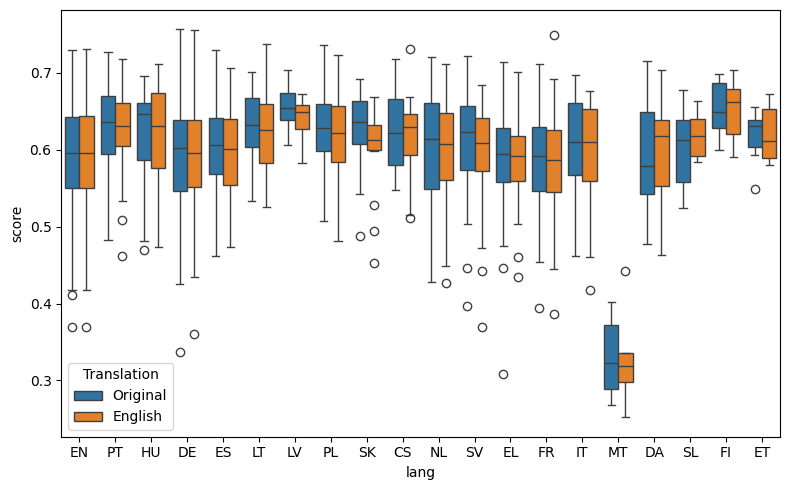

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 5))

# Melt the data to create a single column for scores
melted_data = res[~res['empty_english'] & (res['model'].map(lambda x: x.split('-')[0]) == 'claude')].melt(
    id_vars=['lang'],
    value_vars=['bertscore_original_original', 'bertscore_original_english'],
    var_name='score_type',
    value_name='score'
)
melted_data['score_type'] = melted_data['score_type'].map({
    'bertscore_original_original': 'Original',
    'bertscore_original_english': 'English'
})

# Create grouped boxplot
sns.boxplot(
    data=melted_data,
    x='lang',
    y='score',
    hue='score_type',
    ax=ax
)

ax.legend(title='Translation')
plt.tight_layout()

In [29]:
meta_2 = cross_lingual_attention(data_original, data_english)

Token indices sequence length is longer than the specified maximum sequence length for this model (1007 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1007 > 512). Running this sequence through the model will result in indexing errors


In [30]:
res_2 = pd.DataFrame(meta_2)

In [31]:
res_2['zero_shot'].value_counts()

zero_shot
False    1374
True     1241
Name: count, dtype: int64

In [32]:
res_2['empty_english'] = res_2['summary_english'].map(check_empty)
res_2['empty_original'] = res_2['summary_original'].map(check_empty)

res_2['empty_english'].value_counts()
res_2['empty_original'].value_counts()

at the provided text, this appears to be only a procedural announcement indicating that Mr. Onyszkiewicz (Vice-President) is taking the chair for what appears to be the beginning of a parliamentary session or debate. There is no actual speech content related to the topic of "Guidelines for Member States' employment policies – Broad economic policy guidelines for 2006."

```json
{
  "headline": "",
  "issueSum": "",
  "positionSum": "",
  "argSum": "",
  "propSum": "",
  "quotes": []
}

at the provided text, this appears to be only a procedural announcement indicating that Mr. Onyszkiewicz (Vice-President) is taking the chair for what appears to be the beginning of a parliamentary session or debate. There is no actual speech content related to the topic of "Guidelines for Member States' employment policies – Broad economic policy guidelines for 2006."

```json
{
  "headline": "",
  "issueSum": "",
  "positionSum": "",
  "argSum": "",
  "propSum": "",
  "quotes": []
}

at this parliament

empty_original
False    2203
True      412
Name: count, dtype: int64

/var/folders/y1/3hhxksyn0qb3g_mdrdcs5ldm0000gn/T/ipykernel_98229/1141191503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claude['diff'] = claude['bertscore_original_original'] - claude['bertscore_original_english']


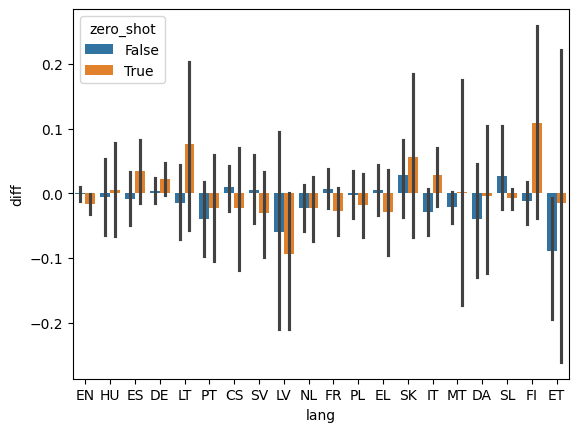

In [52]:
claude = res_2[(res_2['generator_src_model']=='claude')]
claude['diff'] = claude['bertscore_original_original'] - claude['bertscore_original_english']
sns.barplot(x='lang', y='diff', hue='zero_shot', data=claude)
plt.show()

<Axes: xlabel='lang', ylabel='bertscore_original_english'>

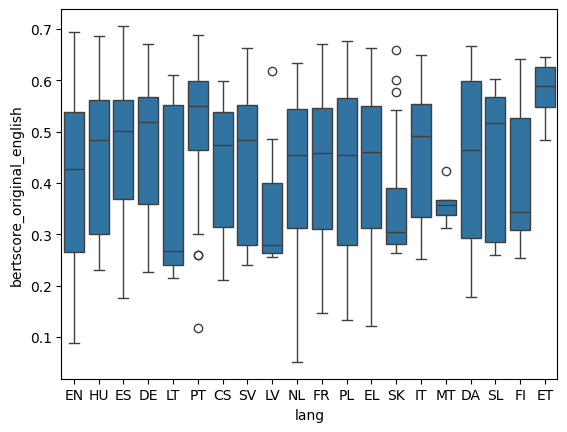

In [53]:
sns.boxplot(data = claude[~claude['zero_shot']], x = 'lang', y = 'bertscore_original_english')

<Axes: xlabel='lang', ylabel='bertscore_original_english'>

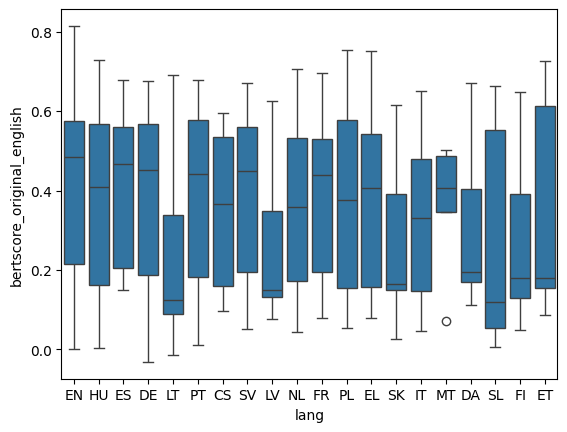

In [54]:
sns.boxplot(data = claude[claude['zero_shot']], x = 'lang', y = 'bertscore_original_english')

<Axes: xlabel='lang'>

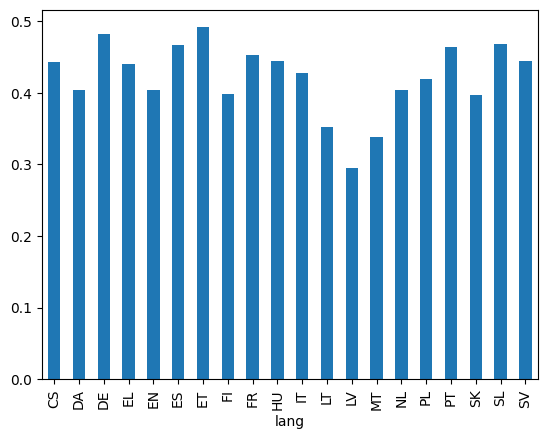

In [55]:
claude[~claude['zero_shot']].groupby('lang')['bertscore_original_original'].mean().plot(kind = 'bar')

<Axes: xlabel='lang'>

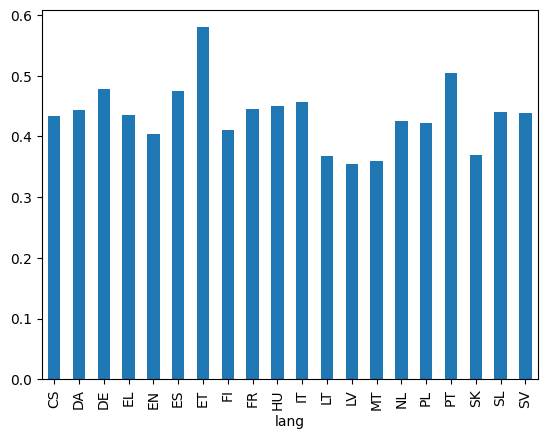

In [56]:
claude[~claude['zero_shot']].groupby('lang')['bertscore_original_english'].mean().plot(kind = 'bar')

<Axes: xlabel='lang'>

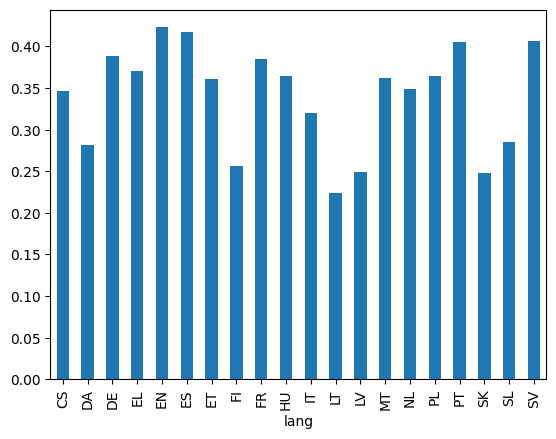

In [57]:
claude[claude['zero_shot']].groupby('lang')['bertscore_original_english'].mean().plot(kind = 'bar')

<Axes: xlabel='lang'>

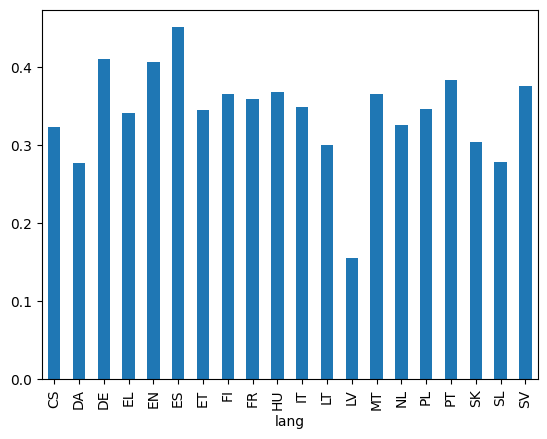

In [58]:
claude[claude['zero_shot']].groupby('lang')['bertscore_original_original'].mean().plot(kind = 'bar')

In [91]:
lang_counts = claude[~claude['zero_shot']]['lang'].value_counts()
language_support_order = list(lang_counts[lang_counts>=10].index)

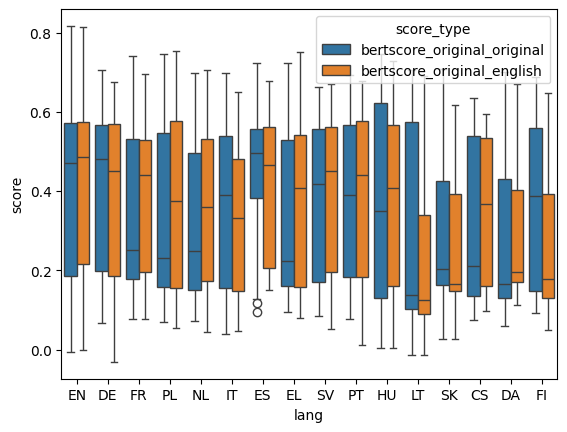

In [92]:
melted_data = claude[claude['zero_shot']].melt(id_vars=['lang'], value_vars=['bertscore_original_original', 'bertscore_original_english'], var_name='score_type', value_name='score')
sns.boxplot(x='lang', y='score', hue='score_type', data=melted_data, order=language_support_order)
plt.show()

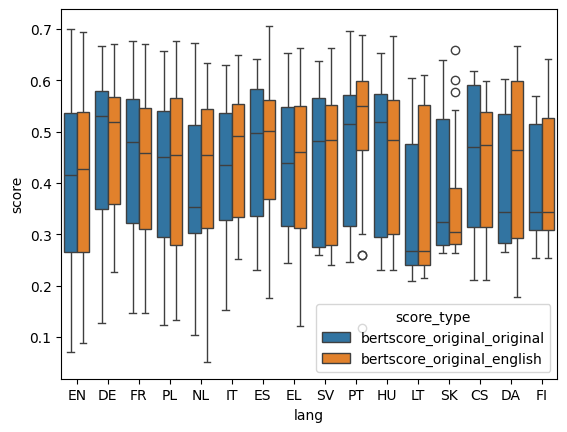

In [93]:
melted_data = claude[~claude['zero_shot']].melt(id_vars=['lang'], value_vars=['bertscore_original_original', 'bertscore_original_english'], var_name='score_type', value_name='score')
sns.boxplot(x='lang', y='score', hue='score_type', data=melted_data, order=language_support_order)
plt.show()

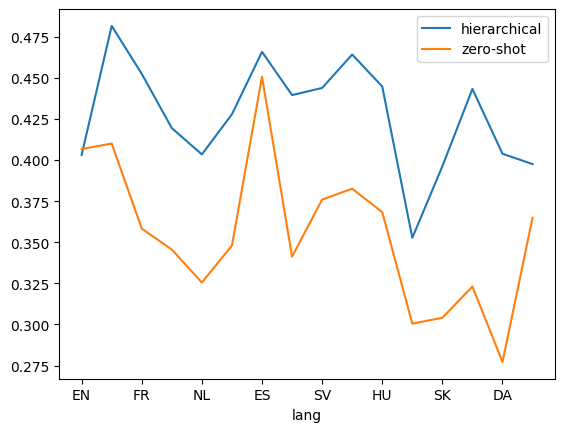

In [94]:
claude[~claude['zero_shot']].groupby('lang')['bertscore_original_original'].mean().reindex(language_support_order).plot(kind='line', label='hierarchical')
claude[claude['zero_shot']].groupby('lang')['bertscore_original_original'].mean().reindex(language_support_order).plot(kind='line', label='zero-shot')
plt.legend()
plt.show()

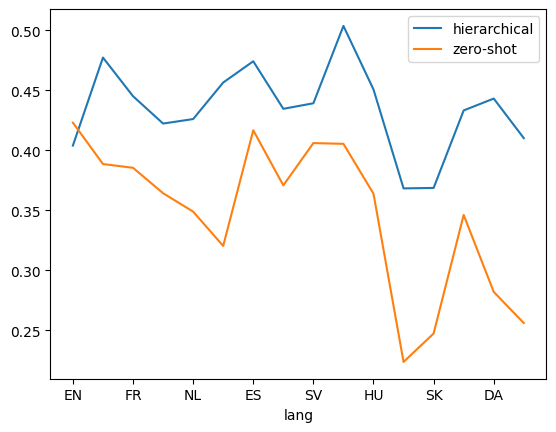

In [95]:
claude[~claude['zero_shot']].groupby('lang')['bertscore_original_english'].mean().reindex(language_support_order).plot(kind='line', label='hierarchical')
claude[claude['zero_shot']].groupby('lang')['bertscore_original_english'].mean().reindex(language_support_order).plot(kind='line', label='zero-shot')
plt.legend()
plt.show()

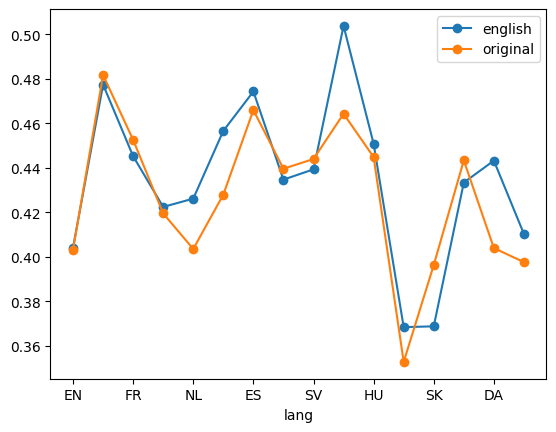

In [96]:
claude[~claude['zero_shot']].groupby('lang')['bertscore_original_english'].mean().reindex(language_support_order).plot(kind='line', label='english', marker = 'o')
claude[~claude['zero_shot']].groupby('lang')['bertscore_original_original'].mean().reindex(language_support_order).plot(kind='line', label='original', marker = 'o')
plt.legend()
plt.show()

In [136]:
import numpy as np 
ids = res_2[['debate_id','intervention_id']].drop_duplicates()
mapping = ids.groupby('debate_id')['intervention_id'].agg(lambda x: np.array(sorted(x)))
def get_speaker_order(debate_id, intervention_id):
    return np.where(mapping[debate_id] == intervention_id)[0][0]/len(mapping[debate_id])
claude['relative_speaker_position'] = claude.apply(lambda x: get_speaker_order(x['debate_id'], x['intervention_id']), axis=1)

/var/folders/y1/3hhxksyn0qb3g_mdrdcs5ldm0000gn/T/ipykernel_98229/1647237089.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claude['relative_speaker_position'] = claude.apply(lambda x: get_speaker_order(x['debate_id'], x['intervention_id']), axis=1)


In [132]:
claude['speaker_bin'] = claude['speaker_order'].apply(lambda x: int(x*20))

/var/folders/y1/3hhxksyn0qb3g_mdrdcs5ldm0000gn/T/ipykernel_98229/2148274468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claude['speaker_bin'] = claude['speaker_order'].apply(lambda x: int(x*20))


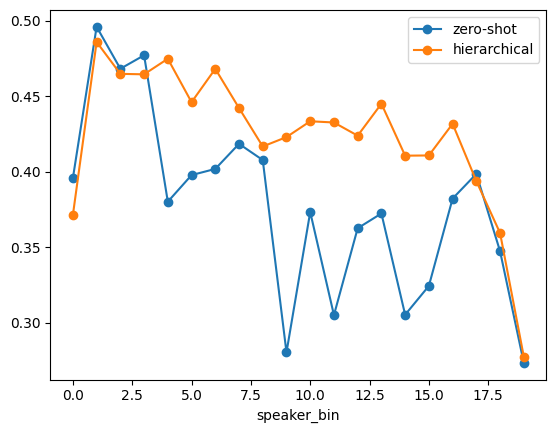

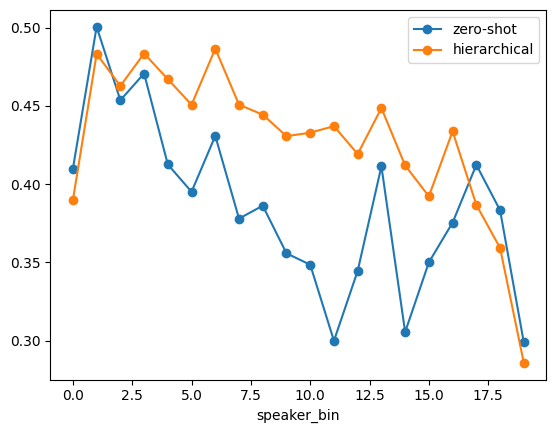

In [133]:
claude[claude['zero_shot']].groupby('speaker_bin')['bertscore_original_original'].mean().plot(kind='line', marker = 'o', label = 'zero-shot')
claude[~claude['zero_shot']].groupby('speaker_bin')['bertscore_original_original'].mean().plot(kind='line', marker = 'o', label = 'hierarchical')
plt.legend()
plt.show()

claude[claude['zero_shot']].groupby('speaker_bin')['bertscore_original_english'].mean().plot(kind='line', marker = 'o', label = 'zero-shot')
claude[~claude['zero_shot']].groupby('speaker_bin')['bertscore_original_english'].mean().plot(kind='line', marker = 'o', label = 'hierarchical')
plt.legend()
plt.show()

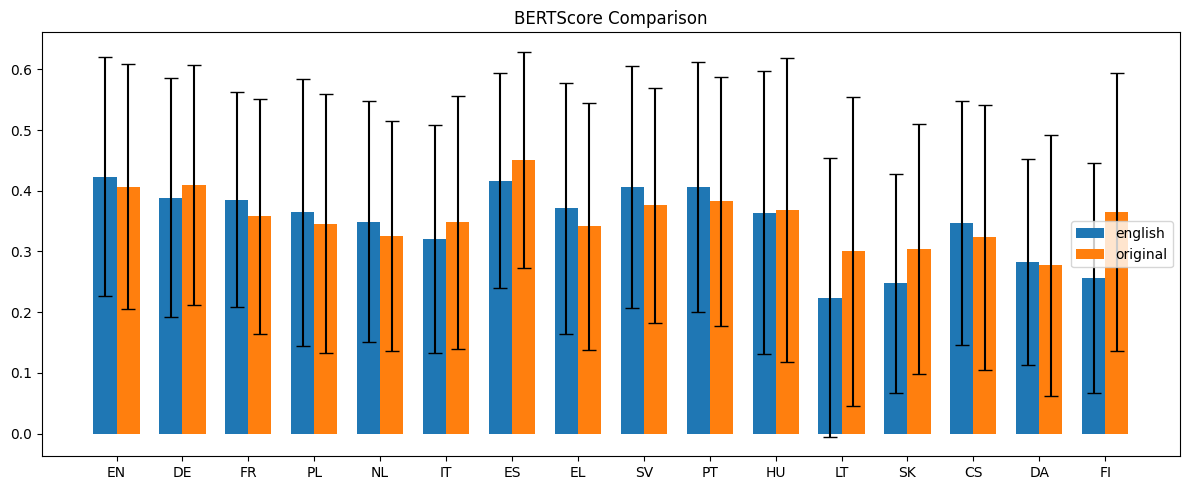

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))

# Calculate mean and std for English scores
eng_means = claude[claude['zero_shot']].groupby('lang')['bertscore_original_english'].mean().reindex(language_support_order)
eng_stds = claude[claude['zero_shot']].groupby('lang')['bertscore_original_english'].std().reindex(language_support_order)

# Calculate mean and std for Original scores  
orig_means = claude[claude['zero_shot']].groupby('lang')['bertscore_original_original'].mean().reindex(language_support_order)
orig_stds = claude[claude['zero_shot']].groupby('lang')['bertscore_original_original'].std().reindex(language_support_order)

# Set up bar positions
x = np.arange(len(language_support_order))
width = 0.35

# Plot bars
ax.bar(x - width/2, eng_means, width, yerr=eng_stds, label='english', capsize=5)
ax.bar(x + width/2, orig_means, width, yerr=orig_stds, label='original', capsize=5)

# Customize plot
ax.set_xticks(x)
ax.set_xticklabels(language_support_order)
ax.set_title('BERTScore Comparison')
ax.legend()

plt.tight_layout()
plt.show()

In [103]:
import numpy as np

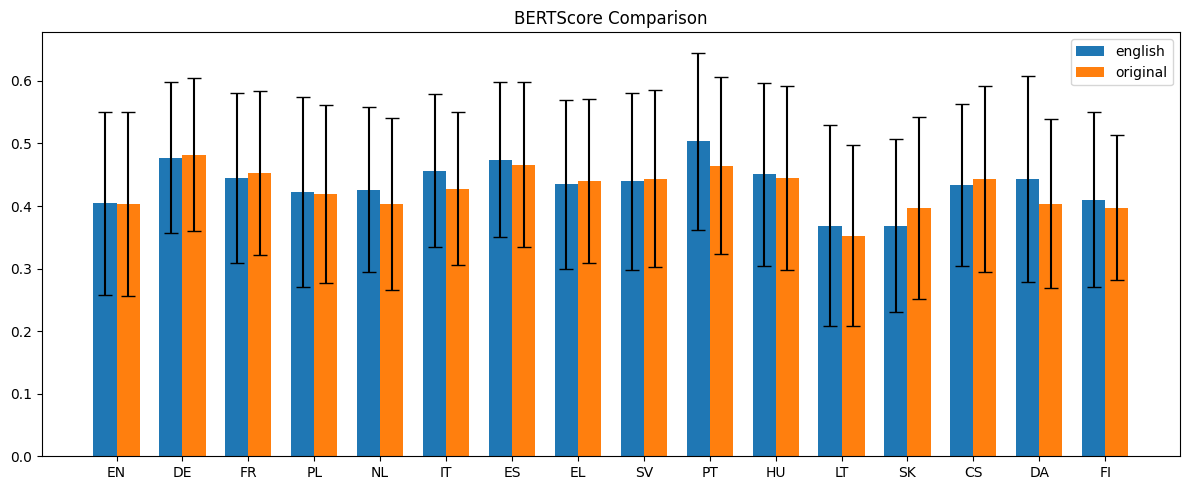

In [104]:

fig, ax = plt.subplots(figsize=(12, 5))

# Calculate mean and std for English scores
eng_means = claude[~claude['zero_shot']].groupby('lang')['bertscore_original_english'].mean().reindex(language_support_order)
eng_stds = claude[~claude['zero_shot']].groupby('lang')['bertscore_original_english'].std().reindex(language_support_order)

# Calculate mean and std for Original scores  
orig_means = claude[~claude['zero_shot']].groupby('lang')['bertscore_original_original'].mean().reindex(language_support_order)
orig_stds = claude[~claude['zero_shot']].groupby('lang')['bertscore_original_original'].std().reindex(language_support_order)

# Set up bar positions
x = np.arange(len(language_support_order))
width = 0.35

# Plot bars
ax.bar(x - width/2, eng_means, width, yerr=eng_stds, label='english', capsize=5)
ax.bar(x + width/2, orig_means, width, yerr=orig_stds, label='original', capsize=5)

# Customize plot
ax.set_xticks(x)
ax.set_xticklabels(language_support_order)
ax.set_title('BERTScore Comparison')
ax.legend()

plt.tight_layout()
plt.show()

In [161]:
lang_counts =claude[claude['zero_shot']]['lang'].value_counts()
lang_rank = lang_counts.rank(ascending=False)
claude['lang_rank'] = claude['lang'].map(lang_rank)/len(lang_rank)

/var/folders/y1/3hhxksyn0qb3g_mdrdcs5ldm0000gn/T/ipykernel_98229/2514256082.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claude['lang_rank'] = claude['lang'].map(lang_rank)/len(lang_rank)


In [ ]:
import statsmodels.api as sm
from statsmodels.othermod.betareg import BetaModel

In [176]:
claude_zero_shot = claude[claude['zero_shot']]
claude_hierarchical = claude[~claude['zero_shot']]

In [199]:
with open('counts.json', 'r') as f:
    counts = json.load(f)


def lang_rank(lang):

    if counts[lang] > 5000000:
        return 'high'
    elif counts[lang] > 1000000:
        return 'medium'
    else:
        return 'low'

claude['lang_rank'] = claude['lang'].apply(lambda x: lang_rank(x))

/var/folders/y1/3hhxksyn0qb3g_mdrdcs5ldm0000gn/T/ipykernel_98229/2216205824.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claude['lang_rank'] = claude['lang'].apply(lambda x: lang_rank(x))


In [261]:
data = claude[~claude['speaker'].str.contains('President.')].melt(id_vars = ['speech_id', 'lang_rank', 'zero_shot', 'relative_speaker_position'], value_vars = ['bertscore_original_original', 'bertscore_original_english'], var_name = 'score_type', value_name = 'bertscore')

In [262]:
data['translated'] =data['score_type'] != 'bertscore_original_original'

In [263]:
data.drop('score_type', axis = 1).to_csv('data/claude_data.csv', index = False)

In [203]:
claude['speech_id'] = claude['debate_id'].astype(str) + '_' + claude['intervention_id'].astype(str)

/var/folders/y1/3hhxksyn0qb3g_mdrdcs5ldm0000gn/T/ipykernel_98229/2440442958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claude['speech_id'] = claude['debate_id'].astype(str) + '_' + claude['intervention_id'].astype(str)


In [163]:
y_var = 'bertscore_original_original'
sub_df = claude[~claude['zero_shot']]

sub_df['speaker_pos_squared'] = sub_df['relative_speaker_position']**2

feature_cols = ['relative_speaker_position', 'speaker_pos_squared']

X = sub_df[feature_cols]
X = sm.add_constant(X)
y = sub_df[y_var]

# Ensure y is in (0, 1)
epsilon = 1e-5
y = sub_df[y_var].clip(lower=epsilon, upper=1 - epsilon)

model = BetaModel(y, X, link=sm.families.links.logit())
result = model.fit()  
print(result.summary())


                                   BetaModel Results                                   
Dep. Variable:     bertscore_original_original   Log-Likelihood:                 674.27
Model:                               BetaModel   AIC:                            -1341.
Method:                     Maximum Likelihood   BIC:                            -1320.
Date:                         Wed, 27 Aug 2025                                         
Time:                                 12:14:29                                         
No. Observations:                         1155                                         
Df Residuals:                             1151                                         
Df Model:                                    2                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const               

/var/folders/y1/3hhxksyn0qb3g_mdrdcs5ldm0000gn/T/ipykernel_98229/263813697.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['speaker_pos_squared'] = sub_df['relative_speaker_position']**2
/Users/eoghancunningham/Library/Caches/pypoetry/virtualenvs/paris-hack-lSjbuFO8-py3.12/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [168]:
y_var = 'bertscore_original_english'
sub_df = claude[claude['zero_shot']]

sub_df['speaker_pos_squared'] = sub_df['relative_speaker_position']**2

feature_cols = ['relative_speaker_position', 'speaker_pos_squared', 'lang_rank']

X = sub_df[feature_cols]
X = sm.add_constant(X)
y = sub_df[y_var]

# Ensure y is in (0, 1)
epsilon = 1e-5
y = sub_df[y_var].clip(lower=epsilon, upper=1 - epsilon)

model = BetaModel(y, X, link=sm.families.links.logit())
result = model.fit()  
print(result.summary())


                                  BetaModel Results                                   
Dep. Variable:     bertscore_original_english   Log-Likelihood:                 305.48
Model:                              BetaModel   AIC:                            -601.0
Method:                    Maximum Likelihood   BIC:                            -575.3
Date:                        Wed, 27 Aug 2025                                         
Time:                                12:17:07                                         
No. Observations:                        1241                                         
Df Residuals:                            1236                                         
Df Model:                                   3                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        

/var/folders/y1/3hhxksyn0qb3g_mdrdcs5ldm0000gn/T/ipykernel_98229/576802929.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['speaker_pos_squared'] = sub_df['relative_speaker_position']**2
/Users/eoghancunningham/Library/Caches/pypoetry/virtualenvs/paris-hack-lSjbuFO8-py3.12/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


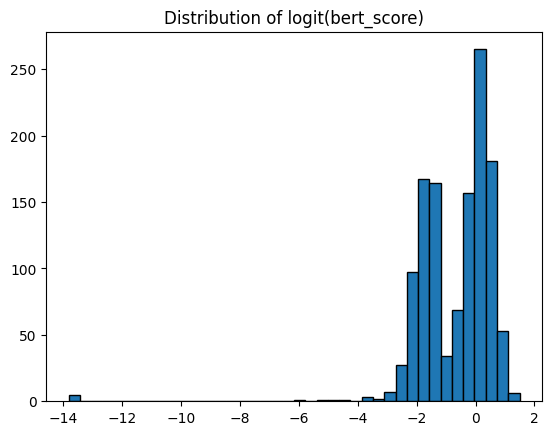

In [170]:
import numpy as np
import matplotlib.pyplot as plt

eps = 1e-6
y_logit = np.log((sub_df['bertscore_original_original'].clip(eps, 1-eps)) / (1-sub_df['bertscore_original_original'].clip(eps, 1-eps)))

plt.hist(y_logit, bins=40, edgecolor='k')
plt.title("Distribution of logit(bert_score)")
plt.show()

In [27]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.genmod.families import Binomial
from statsmodels.othermod.betareg import BetaModel
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [28]:
# Define resource level thresholds
high_threshold = 3500000
med_threshold = 1000000

cmap = {
    'high': '#21618c',
    'medium': '#3498d8',
    'low': '#a9cce3'
}

# Get language counts and sort
lang_counts = claude.groupby('lang')['lang_count'].mean().sort_values(ascending=False)

# Create color map based on resource level
colors = [cmap['high'] if x >= high_threshold else  # Green for high resource
          cmap['medium'] if x >= med_threshold else    # Yellow for medium resource
          cmap['low']                               # Red for low resource
          for x in lang_counts]

# Plot with colors
ax = lang_counts.plot(kind='bar', figsize=(6,4), color=colors)

# Add threshold lines and legend
ax.axhline(y=high_threshold, color='black', linestyle='--', 
           label=f'High resource threshold ({high_threshold:,})')
ax.text(len(lang_counts)-1, high_threshold+100000, f'>={high_threshold:,}', 
        horizontalalignment='right')

ax.axhline(y=med_threshold, color='black', linestyle='--',
           label=f'Medium resource threshold ({med_threshold:,})')
ax.text(len(lang_counts)-1, med_threshold+100000, f'>={med_threshold:,}',
        horizontalalignment='right')

# Add legend entries for resource level colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=cmap['high'], label='High resource'),
    Patch(facecolor=cmap['medium'], label='Medium resource'), 
    Patch(facecolor=cmap['low'], label='Low resource')
]
ax.legend(handles=legend_elements)

#change x label:
ax.set_xlabel('')
plt.title('Wikipedia Article Counts by Language')
plt.savefig('figures/language_counts.png')

NameError: name 'claude' is not defined

In [29]:
df = pd.read_csv('data/claude_data.csv')

In [30]:
df['hierarchical'] = ~df['zero_shot']

In [81]:
y_var = 'bertscore'
sub_df = df

sub_df['speaker_pos_squared'] = sub_df['relative_speaker_position']**2

sub_df['hierarchical_x_relative_speaker_position'] = sub_df['hierarchical'] * sub_df['relative_speaker_position']
sub_df['hierarchical_x_speaker_pos_squared'] = sub_df['hierarchical'] * sub_df['speaker_pos_squared']
feature_cols = ['relative_speaker_position', 'speaker_pos_squared', 'translated', 'hierarchical'] 

reference_lang = 'language_support_high'

lang_dummies = pd.get_dummies(sub_df['lang_rank'], prefix='language_support')
sub_df = pd.concat([sub_df, lang_dummies], axis=1)

for col in feature_cols:
    for lang in lang_dummies.columns.drop(reference_lang):
        print(f'{col}_x_{lang}')
        sub_df[f'{col}_x_{lang}'] = sub_df[col] * sub_df[lang]

feature_cols += [f'{col}_x_{lang}' for col in feature_cols for lang in lang_dummies.columns.drop(reference_lang)]
feature_cols += ['hierarchical_x_relative_speaker_position', 'hierarchical_x_speaker_pos_squared']
feature_cols.extend(lang_dummies.columns.drop(reference_lang))
X = sub_df[feature_cols].astype(float)
X = sm.add_constant(X)
y = sub_df[y_var]

# Ensure y is in (0, 1)
epsilon = 1e-5
y = df[y_var].clip(lower=epsilon, upper=1 - epsilon)

model = BetaModel(y, X, link=sm.families.links.logit())
result = model.fit()  
print(result.summary())


relative_speaker_position_x_language_support_low
relative_speaker_position_x_language_support_medium
speaker_pos_squared_x_language_support_low
speaker_pos_squared_x_language_support_medium
translated_x_language_support_low
translated_x_language_support_medium
hierarchical_x_language_support_low
hierarchical_x_language_support_medium
                              BetaModel Results                               
Dep. Variable:              bertscore   Log-Likelihood:                 1526.5
Model:                      BetaModel   AIC:                            -3017.
Method:            Maximum Likelihood   BIC:                            -2902.
Date:                Thu, 11 Sep 2025                                         
Time:                        12:42:59                                         
No. Observations:                4336                                         
Df Residuals:                    4318                                         
Df Model:                       

In [78]:
y_var = 'bertscore'
sub_df = df[df['zero_shot']]

sub_df['speaker_pos_squared'] = sub_df['relative_speaker_position']**2

# sub_df['hierarchical_x_relative_speaker_position'] = sub_df['hierarchical'] * sub_df['relative_speaker_position']
# sub_df['hierarchical_x_speaker_pos_squared'] = sub_df['hierarchical'] * sub_df['speaker_pos_squared']
feature_cols = ['relative_speaker_position', 'speaker_pos_squared', 'translated'] 

reference_lang = 'language_support_high'

lang_dummies = pd.get_dummies(sub_df['lang_rank'], prefix='language_support')
sub_df = pd.concat([sub_df, lang_dummies], axis=1)

for col in feature_cols:
    for lang in lang_dummies.columns.drop(reference_lang):
        print(f'{col}_x_{lang}')
        sub_df[f'{col}_x_{lang}'] = sub_df[col] * sub_df[lang]

feature_cols += [f'{col}_x_{lang}' for col in feature_cols for lang in lang_dummies.columns.drop(reference_lang)]
# feature_cols += ['hierarchical_x_relative_speaker_position', 'hierarchical_x_speaker_pos_squared']
feature_cols.extend(lang_dummies.columns.drop(reference_lang))
print(feature_cols)
X = sub_df[feature_cols].astype(float)
X = sm.add_constant(X)
y = sub_df[y_var]

# Ensure y is in (0, 1)
epsilon = 1e-5
y = sub_df[y_var].clip(lower=epsilon, upper=1 - epsilon)

model = BetaModel(y, X, link=sm.families.links.logit())
result = model.fit()  
print(result.summary())


relative_speaker_position_x_language_support_low
relative_speaker_position_x_language_support_medium
speaker_pos_squared_x_language_support_low
speaker_pos_squared_x_language_support_medium
translated_x_language_support_low
translated_x_language_support_medium
['relative_speaker_position', 'speaker_pos_squared', 'translated', 'relative_speaker_position_x_language_support_low', 'relative_speaker_position_x_language_support_medium', 'speaker_pos_squared_x_language_support_low', 'speaker_pos_squared_x_language_support_medium', 'translated_x_language_support_low', 'translated_x_language_support_medium', 'language_support_low', 'language_support_medium']
                              BetaModel Results                               
Dep. Variable:              bertscore   Log-Likelihood:                 558.97
Model:                      BetaModel   AIC:                            -1092.
Method:            Maximum Likelihood   BIC:                            -1018.
Date:                Thu, 

In [103]:
def extract_and_plot_coefficients(result, exclude_vars=None, title="Regression Coefficients"):
    """
    Extract coefficients and confidence intervals from statsmodels result object
    and create a coefficient plot with readable variable names
    
    Parameters:
    result: statsmodels regression result object
    exclude_vars: list of variable names to exclude (e.g., ['const', 'precision'])
    title: plot title
    """
    
    if exclude_vars is None:
        exclude_vars = ['const', 'precision']  # Common exclusions for beta regression
    
    # Extract key information from result object
    coefficients = result.params
    conf_int = result.conf_int()
    pvalues = result.pvalues
    std_errors = result.bse
    
    # Create DataFrame
    coef_df = pd.DataFrame({
        'Variable': coefficients.index,
        'Coefficient': coefficients.values,
        'Std_Error': std_errors.values,
        'P_Value': pvalues.values,
        'CI_Lower': conf_int.iloc[:, 0].values,
        'CI_Upper': conf_int.iloc[:, 1].values
    })
    
    # Filter out excluded variables
    coef_df = coef_df[~coef_df['Variable'].isin(exclude_vars)]
    
    # Create readable variable names
    def clean_variable_names(var):
        """Convert technical variable names to readable labels"""
        name_mapping = {
            'const': 'Intercept',
            'relative_speaker_position': 'Speaker Position',
            'speaker_pos_squared': 'Speaker Position²',
            'translated': 'Translated Data',
            'hierarchical': 'Hierarchical Method',
            'relative_speaker_position_x_language_support_low': 'Position × Low Resource',
            'relative_speaker_position_x_language_support_medium': 'Position × Medium Resource',
            'speaker_pos_squared_x_language_support_low': 'Position² × Low Resource',
            'speaker_pos_squared_x_language_support_medium': 'Position² × Medium Resource',
            'translated_x_language_support_low': 'Translated × Low Resource',
            'translated_x_language_support_medium': 'Translated × Medium Resource',
            'hierarchical_x_language_support_low': 'Hierarchical × Low Resource',
            'hierarchical_x_language_support_medium': 'Hierarchical × Medium Resource',
            'language_support_low': 'Low Resource Language',
            'language_support_medium': 'Medium Resource Language',
            'hierarchical_x_speaker_pos_squared': 'Hierarchical × Position²',
            'hierarchical_x_relative_speaker_position': 'Hierarchical × Position',
            'precision': 'Precision Parameter'
        }
        return name_mapping.get(var, var)
    
    # Apply name cleaning
    coef_df['Variable_Clean'] = coef_df['Variable'].apply(clean_variable_names)
    
    # Add significance indicators
    coef_df['Significant'] = coef_df['P_Value'] < 0.05
    coef_df['Highly_Significant'] = coef_df['P_Value'] < 0.001
    
    # Create categories for coloring
    def categorize_variable(var):
        var_lower = var.lower()
        if 'hierarchical' in var_lower:
            return 'Method Effect'
        elif 'translated' in var_lower:
            return 'Translation Effect'
        elif 'pos' in var_lower:
            return 'Position Effect'
        elif 'language_support' in var_lower or 'resource' in var_lower:
            return 'Language Effect'
        else:
            return 'Other'
    
    coef_df['Category'] = coef_df['Variable'].apply(categorize_variable)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(7,6))
    
    # Define colors
    colors = {
        'Position Effect': '#e74c3c',
        'Method Effect': '#3498db',
        'Translation Effect': '#9b59b6',
        'Language Effect': '#27ae60',
        'Other': '#95a5a6'
    }
    
    # Sort by coefficient value for better visualization
    coef_df_sorted = coef_df.sort_values('Coefficient')
    
    y_positions = range(len(coef_df_sorted))
    
    for i, (_, row) in enumerate(coef_df_sorted.iterrows()):
        color = colors.get(row['Category'], '#95a5a6')
        alpha = 1.0 if row['Significant'] else 0.5
        linewidth = 3 if row['Highly_Significant'] else 2 if row['Significant'] else 1
        
        # Plot coefficient point
        ax.scatter(row['Coefficient'], i, s=100, color=color, alpha=alpha, 
                  zorder=3, edgecolors='black', linewidths=0.5)
        
        # Plot confidence interval
        ax.plot([row['CI_Lower'], row['CI_Upper']], [i, i], 
               color=color, alpha=alpha, linewidth=linewidth, zorder=2)
        
        # Add coefficient labels for significant effects
        if row['Significant']:
            label_text = f"{row['Coefficient']:.3f}"
            if row['P_Value'] < 0.001:
                label_text += "***"
            elif row['P_Value'] < 0.01:
                label_text += "**"
            elif row['P_Value'] < 0.05:
                label_text += "*"
                
            ax.text(row['Coefficient'], i+0.2, f"  {label_text}", 
                   va='center', ha='left' if row['Coefficient'] > 0 else 'right',
                   fontweight='bold' if row['Highly_Significant'] else 'normal',
                   fontsize=9)
    
    # Use clean variable names for plotting
    ax.set_yticks(y_positions)
    ax.set_yticklabels(coef_df_sorted['Variable_Clean'], fontsize=11)
    ax.set_xlabel('Coefficient Estimate', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    # Add reference line at zero
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Create legend
    legend_elements = []
    for category, color in colors.items():
        if category in coef_df['Category'].values:
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                                            markerfacecolor=color, markersize=8,
                                            label=category, markeredgecolor='black'))
    
    ax.legend(handles=legend_elements, loc='best', fontsize=9)
    
    # Add significance note
    ax.text(0.54, 0.02, "* p<0.05, ** p<0.01, *** p<0.001", 
           transform=ax.transAxes, fontsize=8, style='italic')
    
    plt.tight_layout()
    plt.savefig('figures/coefficient_plot.png')
    plt.show()
    
    return coef_df

# Alternative: Simple function to just extract the data
def get_coefficient_data(result, exclude_vars=None, clean_names=True):
    """
    Simple function to extract coefficient data as DataFrame
    """
    if exclude_vars is None:
        exclude_vars = ['const', 'precision']
    
    # Extract data
    coef_data = pd.DataFrame({
        'Variable': result.params.index,
        'Coefficient': result.params.values,
        'Std_Error': result.bse.values,
        'P_Value': result.pvalues.values,
        'CI_Lower': result.conf_int().iloc[:, 0].values,
        'CI_Upper': result.conf_int().iloc[:, 1].values
    })
    
    # Filter excluded variables
    coef_data = coef_data[~coef_data['Variable'].isin(exclude_vars)]
    
    # Add clean names if requested
    if clean_names:
        def clean_variable_names(var):
            name_mapping = {
                'relative_speaker_position': 'Speaker Position',
                'speaker_pos_squared': 'Speaker Position²',
                'translated': 'Translated Data',
                'hierarchical': 'Hierarchical Method',
                'relative_speaker_position_x_language_support_low': 'Position × Low Resource',
                'relative_speaker_position_x_language_support_medium': 'Position × Medium Resource',
                'speaker_pos_squared_x_language_support_low': 'Position² × Low Resource',
                'speaker_pos_squared_x_language_support_medium': 'Position² × Medium Resource',
                'translated_x_language_support_low': 'Translated × Low Resource',
                'translated_x_language_support_medium': 'Translated × Medium Resource',
                'hierarchical_x_language_support_low': 'Hierarchical × Low Resource',
                'hierarchical_x_language_support_medium': 'Hierarchical × Medium Resource',
                'language_support_low': 'Low Resource Language',
                'language_support_medium': 'Medium Resource Language',
                'hierarchical_x_speaker_pos_squared': 'Hierarchical × Position²',
                'hierarchical_x_relative_speaker_position': 'Hierarchical × Position'
            }
            return name_mapping.get(var, var)
        
        coef_data['Variable_Clean'] = coef_data['Variable'].apply(clean_variable_names)
    
    return coef_data

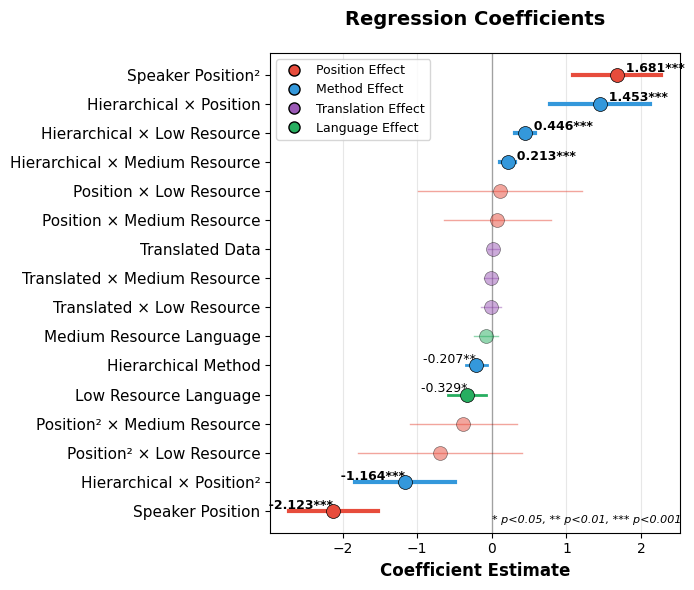

In [104]:
coef_df = extract_and_plot_coefficients(result=result, exclude_vars = ['const', 'precision'])

In [36]:
df

,speech_id,lang_rank,zero_shot,relative_speaker_position,bertscore,translated,hierarchical,speaker_pos_squared,hierarchical_x_relative_speaker_position,hierarchical_x_speaker_pos_squared
0,CRE-20060404-ITEM-006_2-020,high,True,0.025000,0.762653,False,False,0.000625,0.000000,0.000000
1,CRE-20060404-ITEM-006_2-021,high,True,0.050000,0.158215,False,False,0.002500,0.000000,0.000000
2,CRE-20060404-ITEM-006_2-022,high,True,0.075000,0.477886,False,False,0.005625,0.000000,0.000000
3,CRE-20060404-ITEM-006_2-023,high,True,0.100000,0.535368,False,False,0.010000,0.000000,0.000000
4,CRE-20060404-ITEM-006_2-024,low,True,0.125000,0.572100,False,False,0.015625,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
4331,CRE-20060404-ITEM-017_2-380,medium,False,0.666667,0.607949,True,True,0.444444,0.666667,0.444444
4332,CRE-20060404-ITEM-017_2-381,high,False,0.714286,0.444417,True,True,0.510204,0.714286,0.510204
4333,CRE-20060404-ITEM-017_2-383,high,False,0.809524,0.507084,True,True,0.655329,0.809524,0.655329
4334,CRE-20060404-ITEM-017_2-384,high,False,0.857143,0.475331,True,True,0.734694,0.857143,0.734694


In [39]:
df['speaker_bin'] = df['relative_speaker_position'].apply(lambda x: int(x*10))/10

In [40]:
df['speaker_bin']

0       0.0
1       0.0
2       0.0
3       0.1
4       0.1
       ... 
4331    0.6
4332    0.7
4333    0.8
4334    0.8
4335    0.9
Name: speaker_bin, Length: 4336, dtype: float64

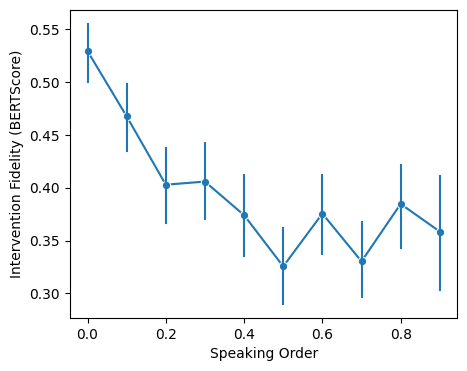

In [106]:
plt.figure(figsize = (5,4))
sns.lineplot(x = 'speaker_bin', y = 'bertscore', marker = 'o', err_style='bars', data = df[df['zero_shot']&df['translated']])
#label x-axis as speaker position
plt.xlabel('Speaking Order')
#label y-axis as bertscore
plt.ylabel('Intervention Fidelity (BERTScore)')
plt.savefig('figures/bertscore_zero_shot.png', bbox_inches='tight', dpi=300)

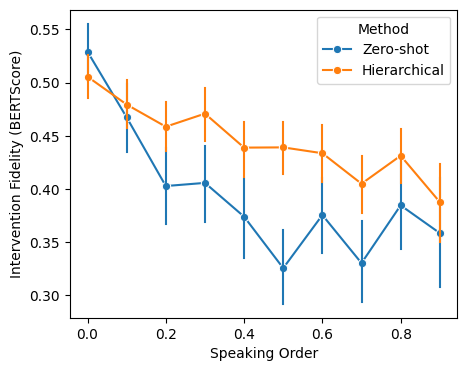

In [105]:
plt.figure(figsize = (5,4))
sns.lineplot(x = 'speaker_bin', y = 'bertscore', hue = 'hierarchical', marker = 'o',  err_style='bars', data = df[df['translated']])
plt.xlabel('Speaking Order')
plt.ylabel('Intervention Fidelity (BERTScore)')
plt.legend(title = 'Method', labels = ['Zero-shot', 'Hierarchical'])
plt.savefig('figures/bertscore_hierarchical.png', bbox_inches='tight', dpi=300)